# UrbanInsight

## Overview
UrbanInsight is a project to densify urban housing. It uses open LIDAR datasets and OpenStreetmap data to find small, ineffizient residiental buildings and flags them for potential replacement.
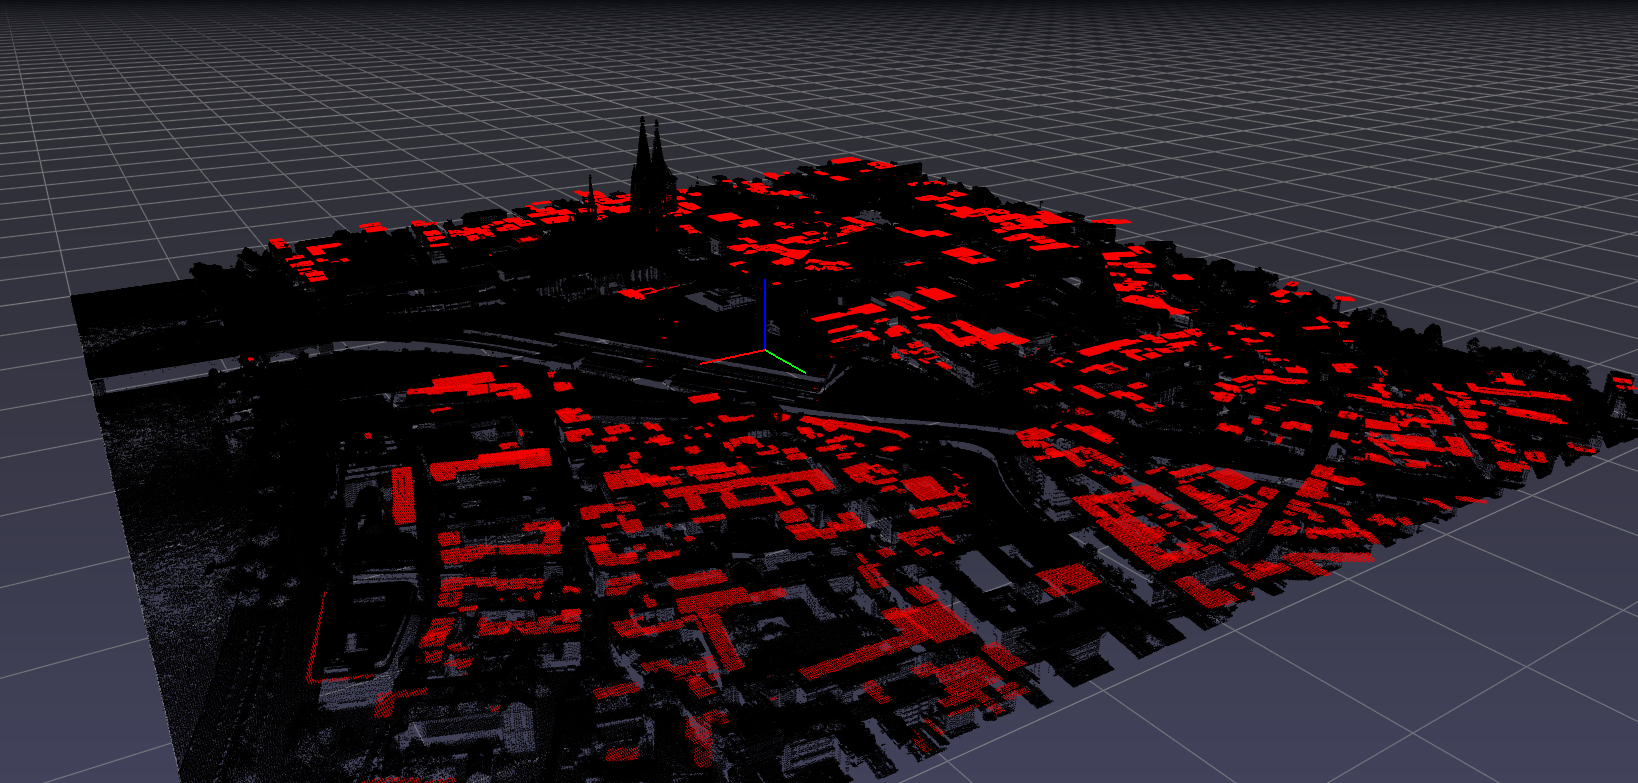
We use a number of Python dependencies to work through the huge dataset:

In [41]:
import numpy as np
import pandas
import geopandas
from shapely.geometry import Point, Polygon
from IPython.display import display, clear_output
import pptk
from sklearn.neighbors import KDTree
import time
import random
random.seed(1337)## With this cluster

In [42]:
def distanceToColor(distance):
    max_distance= 600
    
    r = max_distance / distance
    g = 1 - distance / max_distance
    
    color = [r,g,0]
    #color = [1,0,0]
    return color

In [43]:
def getCenter(bounds):
    min_x, min_y, max_x, max_y = bounds
    
    return Point(((min_x + max_x) /2), ((min_y + max_y)/2))

In [44]:
def pointRound(x, base=5):
    return base * round(x/base)

### Filtering through the dataset
We used a cluster algorythm to filter out and reduce the dataset of unneeded points. This way, we managed to decrease the building time while still having a decent looking set to work on:

In [45]:
def cluster(point_array, base=5):
    tmp = 0
    counter = 0

    lidar_points_clustered = np.copy(lidar_points)

    length = lidar_points_clustered.shape[0]

    for i in range(0, length):

        if(tmp == 9000):
            tmp = 0
            clear_output(wait=True)
            display("progress: " + str(counter / length))

        counter += 1
        tmp += 1

        lidar_points_clustered[i][0] = pointRound(lidar_points_clustered[i][0], base)
        lidar_points_clustered[i][1] = pointRound(lidar_points_clustered[i][1], base)
        lidar_points_clustered[i][2] = pointRound(lidar_points_clustered[i][2], base)

    #lidar_points = np.unique(lidar_points)

    print("before, there were: " + str(length) + " points")

    unique = np.unique(lidar_points_clustered, axis=0)
    
    print("afterwards, there were: " + str(unique.shape[0]) + " points")
    
    return unique

In [46]:
def isInBox(point_x, point_y , bounds):
    #bounds = (minx, miny, maxx, maxy)
    return ((point_x > bounds[0]) and (point_x < bounds[2]) and (point_y > bounds[1]) and (point_y < bounds[3]))

In [47]:
def isPointInPolygon(point, polygon):
    point = Point(point)
    
    polygon = Polygon(polygon)
    
    return polygon.contains(point)
    
#     #polygon = np.insert(polygon, 0, polygon[-1])   
    
#     print("davor")
#     print(polygon)
    
#     polygon = list([polygon[-1]]) + list(polygon)
#     t = -1
    
#     print("danach")
#     print(polygon)
    
#     for i in range(0, (len(polygon) - 1)):
#         t = t * crossProdTest(point, polygon[i], polygon[i + 1])
#         if (t == 0):
#             return True
#     return (t >= 0)
    

In [48]:
def random_points_within(poly, bounds, z_coord, stepping_size = 0.1):
    min_x, min_y, max_x, max_y = bounds  
    
    points = []
    
    x_steps = int((max_x - min_x) / stepping_size)
    
    y_steps = int((max_y - min_y) / stepping_size)
    
    for i in  range(0, x_steps):
        for j in range(0, y_steps):
            next_point = [min_x + (i * stepping_size), min_y + (j * stepping_size), z_coord]
            
            if (isPointInPolygon(next_point, poly)):
                points.append(next_point)
                
    return points

In [49]:
def get_nearest_transport(point):
   #point = (x , y)
    point = (point.x, point.y)
    
    max_distance = 100
    test = []
    for transport in transport_shape['geometry']:
        test.append([transport.x, transport.y])

    transport_tree = KDTree(test)
    nearst_tranport = transport_tree.query(np.array([point[0], point[1]]).reshape(1,-1), 1)
    #return transport_shape.values[nearst_tranport[1][0][0]]
    return nearst_tranport[0]

### Loading the dataset and osm shape files
Make sure to load the correct data and don't forget to switch between windows and linux path conversions

In [50]:
shape_file = "./data/colonge_small/shp_koeln/gis_osm_buildings.shp"
shape  = geopandas.read_file(shape_file)

transport_shape = "./data/colonge_small/shp_koeln/gis_osm_transport.shp"
transport_shape = geopandas.read_file(transport_shape)
transport_shape.drop( transport_shape[ transport_shape['fclass'] == 'taxi' ].index , inplace=True)

lidar_file = "./data/colonge_small/dom1l-fp_32356_5645_1_nw.xyz"
#read the file into a numpy array
lidar_points = np.loadtxt(open(lidar_file, "r"), delimiter=",", skiprows=0)

KeyboardInterrupt: 

In [ ]:
max_index = shape.index.max()

list_polygons = []

for i in range(0, (max_index + 1)):
    current_object = shape.loc[i]
    
    shape_name = current_object['name']
    shape_type = current_object['type']
    
    if (shape_name == None and (shape_type == None or shape_type == "appartment" or shape_type == "house")):
        #print(current_object['geometry'])
        geometry_object = current_object['geometry']
        
        #print(geometry_object.size)

        list_polygons.append([geometry_object.exterior.coords[:], geometry_object.bounds, 0, True])
        
        pure = geometry_object.exterior.coords[:]

In [ ]:
clustered = cluster(lidar_points, 1)
#lidar_clustered_z_sorted_desc = np.flip(clustered[clustered[:,2].argsort()], 0)
lidar_clustered_z_sorted_desc = np.flip(lidar_points[lidar_points[:,2].argsort()], 0)

In [ ]:
tree = KDTree(lidar_clustered_z_sorted_desc)

In [ ]:
max_distance = 50
standart_height = 80

size_cutoff = 1000

length = len(list_polygons)

counter = 0

not_found = 0

for polygon in list_polygons:
    
    if(not((Polygon(polygon[0]).area) > size_cutoff)): #ignore big building

        clear_output(wait=True)
        display("progress: " + str(counter / length))
        counter += 1

        #bounds = (minx, miny, maxx, maxy)
        mid_x = (polygon[1][0] + polygon[1][2]) / 2 #find the mid point for the x coordinate
        mid_y = (polygon[1][1] + polygon[1][3]) / 2 #find the mid point for the y coordinate
        nearest_neighbors = (tree.query_radius(np.array([mid_x, mid_y, standart_height]).reshape(1, -1), max_distance))

        nearest_neighbors = np.sort(nearest_neighbors[0])

        for neighbor_index in nearest_neighbors:
            neighbor_point = lidar_clustered_z_sorted_desc[neighbor_index]

            if(polygon[3]):
                if (isInBox(neighbor_point[0], neighbor_point[1], polygon[1])):
                    if(isPointInPolygon(neighbor_point, polygon[0])):
                        polygon[2] = neighbor_point[2]
                        polygon[3] = False
                        print(".")
                        break

        if(polygon[3]):
            #print("exhausted all " + str(len(nearest_neighbors)) + " but found not fitting one")
            not_found += 1

print("not found: " + str(not_found) + " of " + str(length))

In [ ]:
red = np.array([1,0,0])

new_points = lidar_points

#new_color = np.full((lidar_points.shape[0], 3), 1)
new_color = []

#new_color = (np.full((int(lidar_points.shape[0])), 3))

current_index = 0

counter = 0

not_found = 0

for polygon in list_polygons:
    if(not(polygon[3])): #a value was set

        best_distance = get_nearest_transport(getCenter(polygon[1]))
        polygon = polygon.append(best_distance)  

for polygon in list_polygons:
    clear_output(wait=True)
    display("progress: " + str(counter / length))
    counter += 1
    if(not(polygon[3])): #a value was set
        
        rand_points = np.array(random_points_within(polygon[0], polygon[1], polygon[2], 2.0))
        
        #rand_points = rand_points.reshape(int(rand_points.shape[0] /3), 3)
        
        if (rand_points.shape[0] != 0):
            new_points = np.append(new_points, rand_points, axis=0)
            
            tmp_color = distanceToColor(polygon[4])
            
            for i in range(0, rand_points.shape[0]):
                #new_color = np.append(new_color, tmp_color)
                new_color.append(tmp_color)

#print("debug: " + str(len(new_color)))

#new_debug_array = np.array(new_color)

#print(new_debug_array.shape[0])

#new_color = np.append((np.full((int(lidar_points.shape[0])), 3)), np.array(new_color), axis=0) 

new_color = np.append(np.full((lidar_points.shape[0], 3), 1), np.array(new_color), axis=0) 

#total_size = new_points.shape[0]

#for i in range(lidar_points.shape[0], total_size):
#    new_color[i] = red

# index = lidar_points.shape[0]

# for polygon in list_polygnos:
#     if (polygon[3]):
#         new_color[index] = distanceToColor(polygon[4])
#         index += 1


print("davor: " + str(lidar_points.shape[0]))
    
print("new_c: " + str(new_color.shape[0]))
 
print("new_p: " + str(new_points.shape[0]))


v = pptk.viewer(new_points, new_color)

In [ ]:
#v = pptk.viewer(new_points, new_color)
np.full((lidar_points.shape[0], 3), 1)

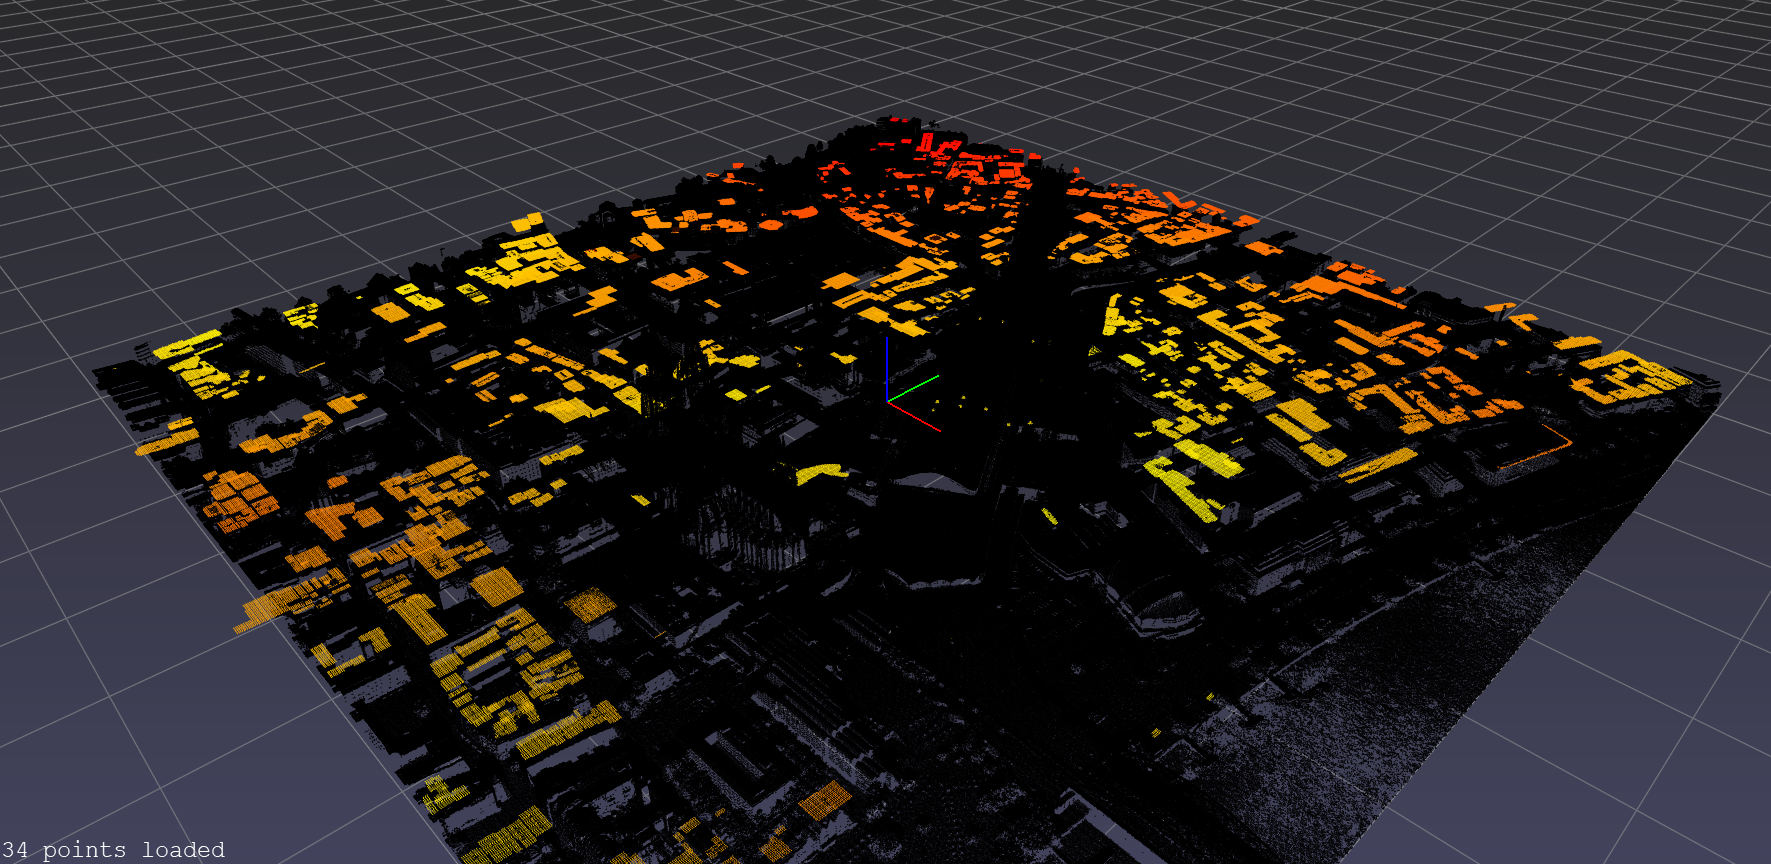